In [6]:
%matplotlib inline
import numpy as np
from sklearn.covariance import empirical_covariance

from regain.utils import structure_error
from regain import datasets
from regain.covariance.missing_multiple_graphical_lasso import MissingMultipleGraphicalLasso
from regain.covariance.latent_time_graphical_lasso_ import LatentTimeGraphicalLasso

from sklearn.datasets.base import Bunch
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

# import R's "base" package
glasso = importr('JGL')


# config
np.random.seed(0)
n_samples = 100
T = 10
beta = 1

In [7]:
from regain.covariance.time_graphical_lasso_ import time_graphical_lasso
from sklearn.impute import SimpleImputer
from regain.datasets.multi_class import make_multiclass_dataset

In [9]:
from tqdm import tqdm
import time
import warnings 

import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

# import R's "base" package
glasso = importr('JGL')

warnings.simplefilter('ignore')
results = {}
results_lvglasso = {}


kernel = np.zeros((T, T))
for i in range(T):
    for j in range(i+1, T):
        kernel[i, j] = beta


thetas = []
for n_dim_obs in   tqdm(np.logspace(1, 2, 5)):
    res, elapsed_time = [], []
    res1, elapsed_time1 = [], []
    res2, elapsed_time2 = [], []
    
    res3, elapsed_time3 = [], []
    tt = [] 
    
    alpha = np.log(n_dim_obs)/n_samples
    tau = 2*np.sqrt(n_dim_obs/n_samples)
   # alpha2 = np.sqrt(p/n)
    n_dim_lat = int(0.05*n_dim_obs)
    for i in range(10):
        mgl = MissingMultipleGraphicalLasso(alpha=alpha, kernel=kernel, psi='l1', 
                                        tol=1e-3, rtol=1e-3, verbose=0, max_iter=500)
#         ltgl = LatentTimeGraphicalLasso(alpha=alpha, tau=tau, eta=beta,  beta=beta, psi='laplacian', 
#                                  tol=1e-3, rtol=1e-3,verbose=0, max_iter=500)

        n_dim_obs = int(n_dim_obs)
        
        retry=True
        while(retry):
            try:
                samples, _= make_multiclass_dataset(
                    n_samples=n_samples, n_dim_obs=n_dim_obs, n_classes=10)
                dataset = samples['gaussian']
                tt.append(dataset.thetas)
                retry=False
            except AssertionError:
                retry=True
        
        #to_remove = int(T*n_samples*n_dim_obs*0.05)
        X = dataset.X
#         X[np.random.choice(np.arange(0, T*n_samples), to_remove),
#           np.random.choice(np.arange(0, n_dim_obs), to_remove)] = np.nan

#         X_ = np.zeros((X.shape[0], n_dim_obs + n_dim_lat))
#         X_[:] = np.nan 
#         X_[:, n_dim_lat:] = dataset.X
        tic = time.time()
        results_static = mgl.fit(X, dataset.y).precision_
        tac = time.time() - tic    
        res.append(results_static)
        elapsed_time.append(tac)

#         tic = time.time()
#         precision_inputing = ltgl.fit(X, dataset.y).precision_
#         tac = time.time() - tic  
#         res3.append(precision_inputing)
#         elapsed_time3.append(tac)
    
        X = [SimpleImputer(strategy='mean').fit_transform(X[dataset.y == cl])
                        for cl in np.unique(dataset.y) ]
        X_r = [ robjects.r.matrix(X[t], nrow=X[t].shape[0], ncol=X[t].shape[1]) for t in range(len(X))]
        try:
            result = glasso.JGL(X_r, 'fused', alpha, beta,**{'tol':1e-3, 'maxiter':500, 'return.whole.theta':True})#,
                                #robjects.r.matrix(np.zeros((n_dim_obs, n_dim_lat)), nrow=n_dim_obs, ncol=n_dim_lat))
            tac = time.time() - tic
            res2.append(np.array(np.array([np.array(t) for t in result.rx2('theta')])))
            elapsed_time2.append(tac)
        except rpy2.rinterface.RRuntimeError:
            continue
        
        X = dataset.X
       
        X = [X[dataset.y == cl] for cl in np.unique(dataset.y) ]
        X = [x[~np.isnan(x).any(axis=1)] for x in X]
        X_r = [ robjects.r.matrix(X[t], nrow=X[t].shape[0], ncol=X[t].shape[1]) for t in range(len(X))]
        try:
            result = glasso.JGL(X_r, 'fused', alpha, beta,**{'tol':1e-3, 'maxiter':500, 'return.whole.theta':True})#,
                                #robjects.r.matrix(np.zeros((n_dim_obs, n_dim_lat)), nrow=n_dim_obs, ncol=n_dim_lat))
            tac = time.time() - tic
            res3.append(np.array(np.array([np.array(t) for t in result.rx2('theta')])))
            elapsed_time3.append(tac)
        except rpy2.rinterface.RRuntimeError:
            continue
    thetas.append(tt)
    results[('mtgl', n_dim_obs)] = dict(res=res, elapsed_time=elapsed_time)
    results[('jgl(inputing)', n_dim_obs)] = dict(res=res2, elapsed_time=elapsed_time2)
    results[('jgl(complete)', n_dim_obs)] = dict(res=res3, elapsed_time=elapsed_time3)

100%|██████████| 5/5 [13:36:10<00:00, 9794.05s/it] 


In [4]:
ress = {}
for k, v in results.items():
    ress[k] = v
for k, v in results_lvglasso.items():
    ress[k] = v

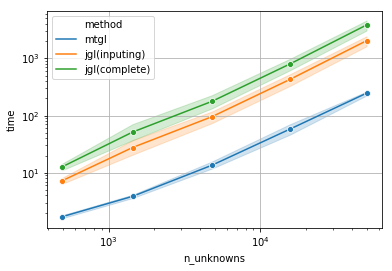

In [10]:
import pandas as pd
from regain.utils import flatten
from matplotlib import rcParams
rcParams.update({'font.size': 10})
df = pd.DataFrame(
    flatten([[(k[0], T*int(k[1] * k[1]-1) // 2 * 1, x) 
              for x in results[k]['elapsed_time']] for k in results]),
    columns=['method', 'n_unknowns', 'time'])

import seaborn as sns
from matplotlib import pyplot as plt
f, ax = plt.subplots()
#plt.yscale("log")
g = sns.lineplot(data=df, hue='method', x='n_unknowns', y='time', marker='o')
g.set_yscale("log");
plt.grid()
g.set_xscale("log");
# plt.savefig("/home/vero/Dropbox (DIBRIS)/PhD/papers/_inprearation/MachineLearning_2020/machine_learning/results_tmgl/scalability_partial_data_5_percent_JGL.pdf", dpi=200, bbox_inches='tight',
#            transparent=True)

In [ ]:
[r.reshape((10, 33, 33)).shape for r in results[('lvglasso', 31)]['res']]

In [32]:
from importlib import reload 

import regain.utils; reload(regain.utils)
from regain.utils import mean_structure_error
n_dim_lat = []
for n_dim_obs in tqdm(np.logspace(1, 2, 5)):
    n_dim_lat.append(int(0.075*n_dim_obs))
mat_results = np.zeros((5, 3))
for i, (t, l) in enumerate(zip(thetas, n_dim_lat)):
    _,d, _ = t[0].shape
    print(d, l)
   # print(results[('mgl', d)])
    a1 = float(mean_structure_error(t, results[('mtgl', d)]['res'], multiple=True)['mcc'].split('+/-')[0])
    mat_results[i, 0] = a1
    a2 = float(mean_structure_error(t, [np.array(r) for r in results[('jgl(inputing)', d)]['res']], multiple=True)['mcc'].split('+/-')[0])
    mat_results[i, 1] = a2
#     if d> 10:
#         print(results[('lvglasso', d)]['res'][0].shape)
#     a3 = float(mean_structure_error(t, [np.array([r_[l:, l:] for r_ in r.reshape((10, d+l, d+l))]) for r in results[('lvglasso', d)]['res']], multiple=True)['mcc'].split('+/-')[0])
#     mat_results[i, 2] = a3





100%|██████████| 5/5 [00:00<00:00, 32870.72it/s]A


10 0
17 1
31 2
56 4
100 7


In [ ]:
324//18

In [ ]:
mat_resu

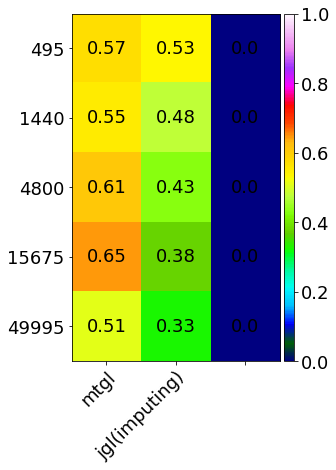

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams

rcParams.update({'font.size':18})
fig, ax = plt.subplots(figsize=(5,8))
im = ax.imshow(mat_results, vmin=0, vmax=1, cmap='gist_ncar')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


# We want to show all ticks...
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(5))
# ... and label them with the respective list entries
ax.set_xticklabels(['mtgl', 'jgl(imputing)'])
ax.set_yticklabels(np.unique(df['n_unknowns']))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(3):
        text = ax.text(j, i, round(mat_results[i, j],2),
                       ha="center", va="center", color="k")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
# plt.savefig("../results_tmgl/MCC_latent_data_7_5_percent_missing.pdf", dpi=200, bbox_inches='tight',
#            transparent=True)
# plt.show()

In [ ]:
from regain.utils import mean_structure_error


mat_results_std = np.zeros((5, 3))
for i, (t, l) in enumerate(zip(thetas, n_dim_lat)):
    _,d, _ = t[0].shape
   # print(results[('mgl', d)])
    a1 = float(mean_structure_error(t, [np.array([r_[l:, l:] for r_ in r]) for r in results[('mtgl', d)]['res']], multiple=True)['mcc'].split('+/-')[1])
    mat_results_std[i, 0] = a1
    a2 = float(mean_structure_error(t, [np.array(r) for r in results[('ltgl', d)]['res']], multiple=True)['mcc'].split('+/-')[1])
    mat_results_std[i, 1] = a2
    a3 = float(mean_structure_error(t, [np.array([r_[l:, l:] for r_ in r.reshape((10, d+l, d+l))]) for r in results[('lvglasso', d)]['res']], multiple=True)['mcc'].split('+/-')[1])
    mat_results[i, 2] = a3

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))

from matplotlib import rcParams

rcParams.update({'font.size':18})
im = ax.imshow(mat_results_std, vmin=0, vmax=0.3, cmap='gist_ncar')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

# We want to show all ticks...
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(5))
# ... and label them with the respective list entries
ax.set_xticklabels(['mtgl', 'ltgl', 'lvglasso'])
ax.set_yticklabels(np.unique(df['n_unknowns']))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(3):
        text = ax.text(j, i, round(mat_results_std[i, j],2),
                       ha="center", va="center", color="k")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.savefig("../results_tmgl/MCC_STD_latet_data_7_5_percent_missing.pdf", dpi=200, bbox_inches='tight',
           transparent=True)
plt.show()

# ROC CURVES

In [ ]:
from regain.plotting.results import plot_curve

for t in thetas:
    _,d, _ = t[0].shape
    if d < 50:
        _dict = {'mtgl': [np.array(r) for r in results[('mtgl',d )]['res']], 
                           'tgl(inputing)': [np.array(r) for r in results[('tgl(inputing)',d )]['res']],
                           'mglasso': [np.array(r) for r in results[('mglasso',d )]['res']],
                'tgl(complete)': [np.array(r) for r in results[('tgl(complete)',d )]['res']],
                           }
    else:
        _dict = {'mtgl': [np.array(r) for r in results[('mtgl',d )]['res']], 
                           'tgl(inputing)': [np.array(r) for r in results[('tgl(inputing)',d )]['res']]}
    plot_curve(t, _dict, multiple=True, filename="../results_tmgl/roc_curve_10_percent_"+str(d)+"dimensions.pdf",
              fontsize=20)
    plot_curve(t, _dict, multiple=True, filename="../results_tmgl/roc_curve_10_percent_"+str(d)+"dimensions.pdf",
              fontsize=20, mode='pr')